## Example: Deploying a Classifier
This notebook shows how one might use a previously trained model to classify a subset of the ISBI 2012 data set.  This assumes you have a local copy of the ISBI 2012 data (available from the [ISBI challenge website](http://brainiac2.mit.edu/isbi_challenge/home)) and access to a file containing trained weights.  You will also need to have [Keras](http://keras.io/) (along with a suitable backend) installed.

It helps to have a reasonably good GPU when running this example.  e.g. I run this notebook remotely on our GPU cluster using the instructions provided [here](http://www.datasciencebytes.com/bytes/2015/12/18/using-jupyter-notebooks-securely-on-remote-linux-machines/).

---

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os, copy, logging

# pick up local libraries
sys.path.append(os.path.join('.', 'src'))
sys.path.append(os.path.join('.', 'src', 'thirdparty'))

import numpy as np
import pylab as plt

import emlib
import models as emm
from deploy import deploy_model


try:
    logger
except:
    # do this precisely once
    logger = logging.getLogger("deploy_model")
    logger.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setFormatter(logging.Formatter('[%(asctime)s:%(name)s:%(levelname)s]  %(message)s'))
    logger.addHandler(ch)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This example uses the ISBI 2012 test volume as the input to the CNN.  One could replace this with a different file, or perhaps an API call to some neuro database [e.g. see here for some good examples](https://github.com/neurodata/kasthuri2015/blob/master/claims/claim0_get_data.ipynb).

Data shape is: (30, 1, 512, 512)


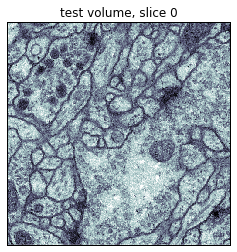

In [7]:
# Load previously trained weights and test volume.
weightsFile = './Models/ISBI2012/weights_epoch_025.h5'

dataFile = './data/ISBI2012/test-volume.tif'
X = emlib.load_cube(dataFile)

# show some details.  Note that data tensors are assumed to have dimensions:
#   (#slices, #channels, #rows, #columns)
#
print('Data shape is: %s' % str(X.shape))
plt.imshow(X[0,0,...], interpolation='none', cmap='bone')
plt.title('test volume, slice 0')
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()

[2016-03-16 16:13:57,355:deploy_model:WARNING]  No output file specified - are you sure this is what you want?
[2016-03-16 16:13:57,359:deploy_model:INFO]  X volume dimensions: (1, 1, 512, 512)
INFO:deploy_model:X volume dimensions: (1, 1, 512, 512)
[2016-03-16 16:13:57,361:deploy_model:INFO]  X values min/max:    0, 1
INFO:deploy_model:X values min/max:    0, 1
[2016-03-16 16:13:57,363:deploy_model:INFO]  initializing CNN...
INFO:deploy_model:initializing CNN...
[2016-03-16 16:14:20,645:deploy_model:INFO]  evaluating volume...
INFO:deploy_model:evaluating volume...
[2016-03-16 16:14:21,416:deploy_model:INFO]  after masking, will evaluate 10.00% of data
INFO:deploy_model:after masking, will evaluate 10.00% of data
[2016-03-16 16:14:21,477:deploy_model:INFO]    last pixel [  0   1 473] (0.38% complete)
INFO:deploy_model:  last pixel [  0   1 473] (0.38% complete)
[2016-03-16 16:14:36,111:deploy_model:INFO]  Complete!
INFO:deploy_model:Complete!


Class probabilities shape: (1, 2, 512, 512)


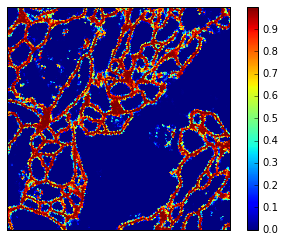

In [10]:
# In the interest of time, only deploy on one slice (z-dimension) of the test volume 
# *and* we will only evaluate a subset of the pixels in that slice.
#
# Note: depending upon your system (e.g. CPU vs GPU) this may take a few minutes...
#
P0 = deploy_model(X, weightsFile, slices=[0,], evalPct=.1, log=logger)

# The shape of the probability estimate tensor is:
#    (#slices, #classes, #rows, #cols)
# While it is redundant to return both class estimates for binary classification
# problems (one estimate is just 1.0 minus the other) we keep the extra data
# for consistency with multi-class problems.
print('Class probabilities shape: %s' % str(P0.shape))

# Use a simple interpolation scheme to fill in "missing" values 
# (i.e. those pixels we did not evaluate using the CNN).
# 
# For an estimate you wanted to do science with, you would probably
# do some postprocessing (as well as put more energy into the CNN design)
Pint = emlib.interpolate_nn(P0)
plt.imshow(Pint[0,0,...]); plt.colorbar()
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()
